In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

In [3]:
#loading data
df = pd.read_csv('MBTI_500.csv')
df.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


# Personality type distribution

## Findings:

### From the first plot:

- INTP (23.5%) and INTJ (21.1%) dominate the dataset.

- Rare types like ESFJ, ESFP, ESTJ account for <1% each.

This imbalance indicates the dataset is heavily skewed toward introverted, intuitive, and thinking types.



### From the second plot:

- Introverts (I) vastly outnumber extraverts.

- Intuitives (N) are extremely dominant.

This suggests that your data comes from a niche population (e.g., Reddit or forums where introspective users are more common).

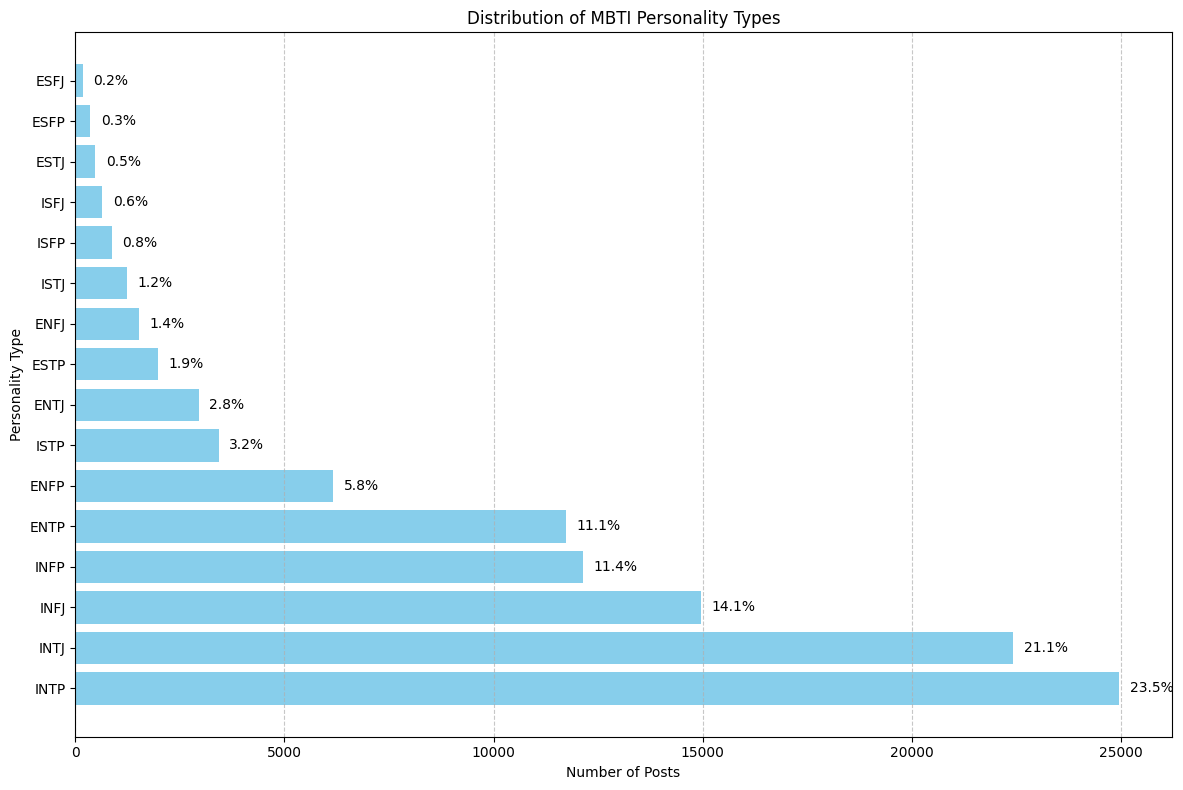

In [6]:
type_counts = df['type'].value_counts()
type_percent = (type_counts / type_counts.sum()) * 100

plt.figure(figsize=(12, 8))
bars = plt.barh(type_counts.index, type_counts.values, color='skyblue')
plt.title('Distribution of MBTI Personality Types')
plt.xlabel('Number of Posts')
plt.ylabel('Personality Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels at the end of bars
for bar, percent in zip(bars, type_percent.values):
    width = bar.get_width()
    plt.text(width + max(type_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
             f'{percent:.1f}%', va='center')

plt.tight_layout()
plt.show()

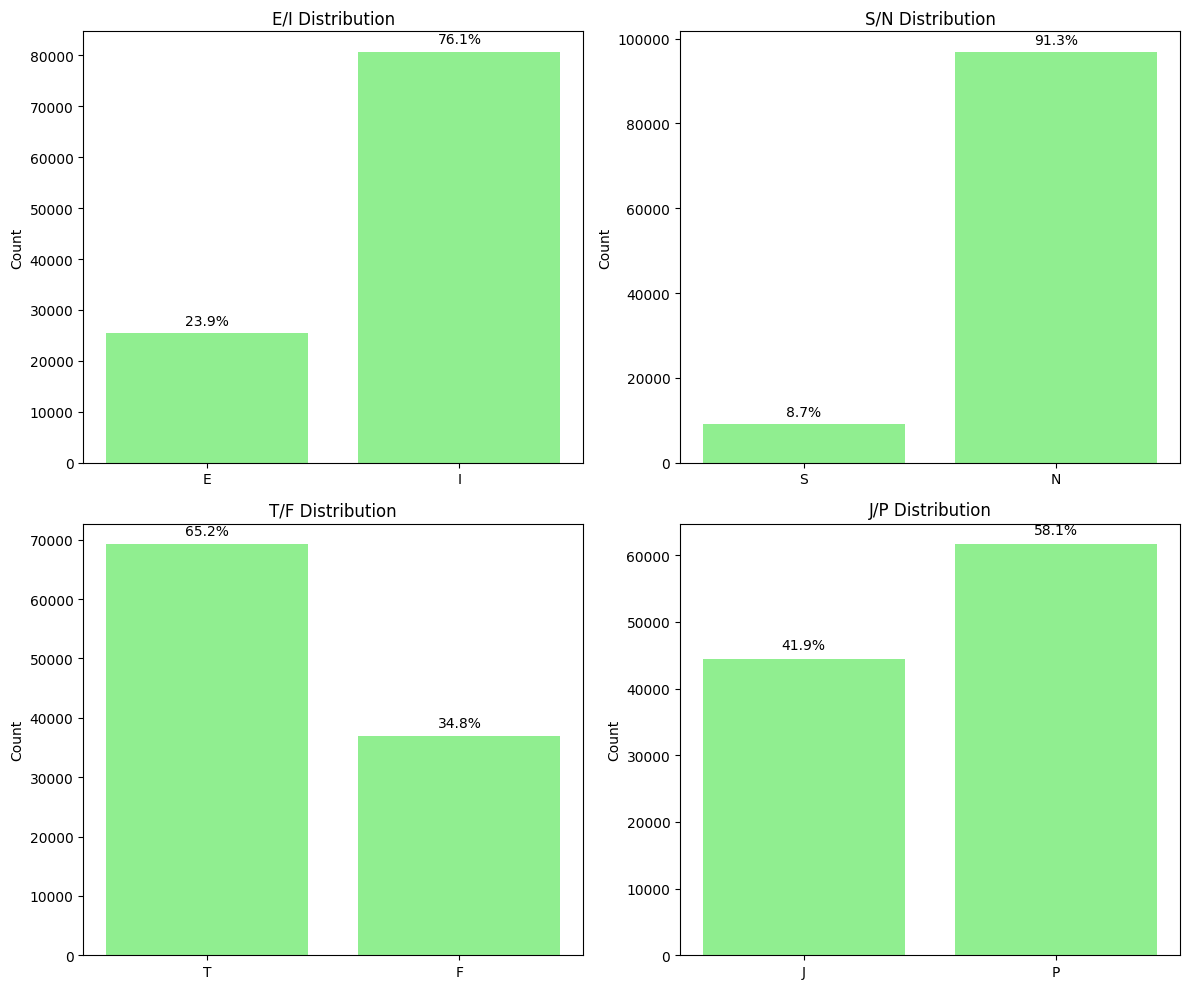

In [8]:
type_series = df['type']

# Initialize letter groupings
letter_groups = {
    'E/I': {'E': 0, 'I': 0},
    'S/N': {'S': 0, 'N': 0},
    'T/F': {'T': 0, 'F': 0},
    'J/P': {'J': 0, 'P': 0},
}

# Count each letter occurrence
for mbti in type_series:
    letter_groups['E/I'][mbti[0]] += 1
    letter_groups['S/N'][mbti[1]] += 1
    letter_groups['T/F'][mbti[2]] += 1
    letter_groups['J/P'][mbti[3]] += 1

# Plot each pair
plt.figure(figsize=(12, 10))

for i, (pair, counts) in enumerate(letter_groups.items(), 1):
    plt.subplot(2, 2, i)
    labels = list(counts.keys())
    values = list(counts.values())
    total = sum(values)
    bars = plt.bar(labels, values, color='lightgreen')
    plt.title(f'{pair} Distribution')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                 f'{(value/total)*100:.1f}%', ha='center', va='bottom')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Potential Concerns for Predictive Modeling

### 1. Class Imbalance Will Hurt Model Performance
A model may learn to always predict INTP/INTJ and still get high accuracy.

Rare types will have very poor recall/F1-scores unless handled properly.

#### Potential Fix:
Use stratified sampling, class weighting, or oversampling (SMOTE) to balance during training.

Consider grouping by MBTI letters (predict I/E, N/S, T/F, J/P separately) to reduce class granularity.

### 2. Overfitting to Majority Traits
A model might learn to rely heavily on words common to INTP/INTJ, making predictions biased.

This hurts generalization to underrepresented types.

#### Potential Fix:
Regularize model (dropout, L2, etc.).

Use balanced batches during training.

### 3. Poor Representation of Extraverts and Sensors
Extraverts (E) and Sensors (S) have very little training data.

The model may not learn their unique linguistic traits.

#### Potential Fix:
Collect more balanced data or augment minority-type examples.

Could also reframe the problem: predict traits one-by-one (I vs E), instead of all 16 types.

### 4. Metrics Beyond Accuracy Are Essential
Accuracy will be misleading due to imbalance.

#### Potential Fix:

Precision/Recall/F1-score per class

Confusion matrix

Macro/micro-averaged metrics


# Top Frequent Words in Each Type

Not that useful looking at the result. Too many overlapping words. 

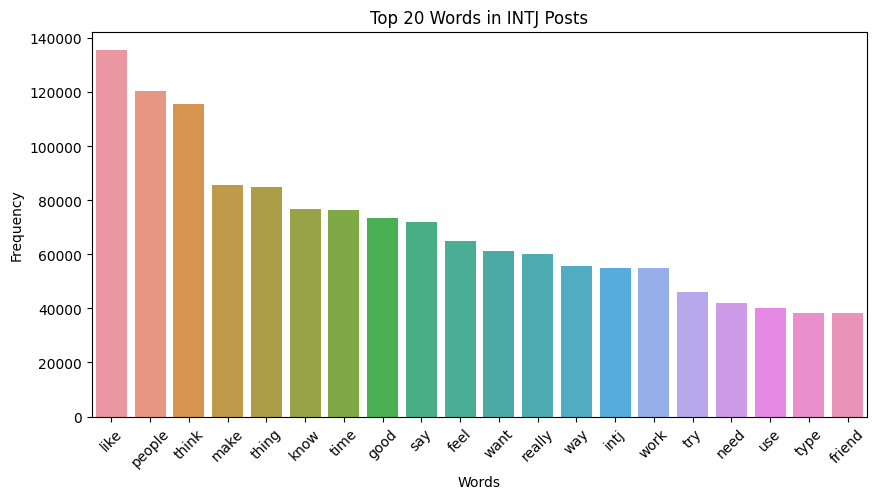

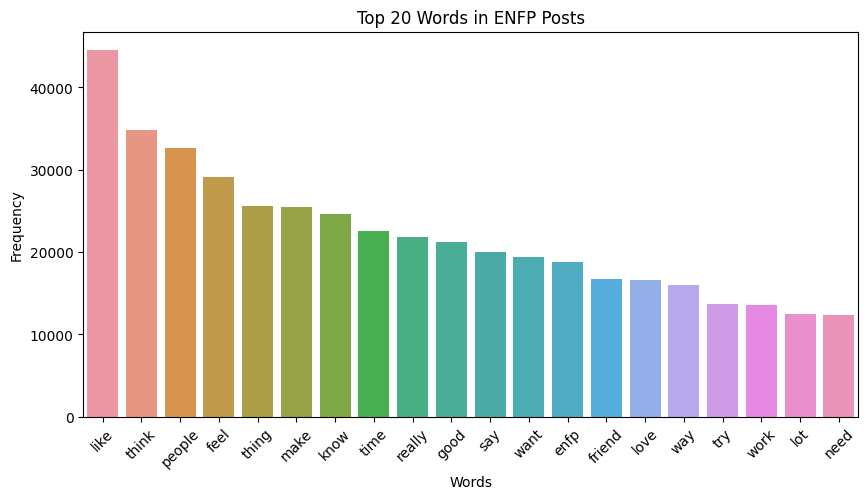

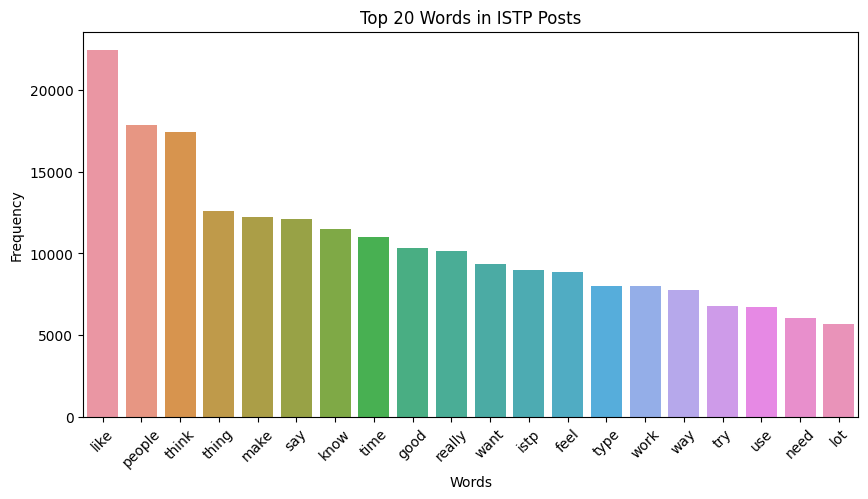

In [17]:
top_words_per_type = {}

for mbti_type in df['type'].unique():
    texts = df[df['type'] == mbti_type]['posts']
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    word_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    freq = dict(zip(vocab, word_counts))
    top_words = Counter(freq).most_common(20)
    top_words_per_type[mbti_type] = top_words

# Visualize for a few types (you can loop for all later)
for mbti_type in ['INTJ', 'ENFP', 'ISTP']:  
    words, counts = zip(*top_words_per_type[mbti_type])
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(f"Top 20 Words in {mbti_type} Posts")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.xticks(rotation=45)
    plt.show()

In [13]:
# Group posts by type
grouped = df.groupby('type')['posts'].apply(lambda texts: ' '.join(texts))

# Fit TF-IDF on all combined posts
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(grouped)

# Get top words per type
feature_names = tfidf.get_feature_names_out()
top_words_per_type = {}

for i, type_ in enumerate(grouped.index):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[-10:][::-1]
    top_words = [(feature_names[j], row[j]) for j in top_indices]
    top_words_per_type[type_] = top_words

In [14]:
top_words_per_type

{'ENFJ': [('like', 0.33866288950454054),
  ('think', 0.29670635600246487),
  ('people', 0.2871940732161164),
  ('feel', 0.23899210152098369),
  ('make', 0.20257639267223557),
  ('know', 0.20187177913250606),
  ('thing', 0.18902859597652716),
  ('say', 0.17474415785291972),
  ('really', 0.17426373953037688),
  ('good', 0.16529593084291033)],
 'ENFP': [('like', 0.35521554035181785),
  ('think', 0.2775402963818192),
  ('people', 0.2605732547919858),
  ('feel', 0.23196529181063133),
  ('thing', 0.20377991022225675),
  ('make', 0.2031898909188509),
  ('know', 0.1958066763924478),
  ('time', 0.17933397530006256),
  ('really', 0.17435867739026178),
  ('good', 0.1687295743064167)],
 'ENTJ': [('like', 0.329631331715541),
  ('people', 0.27952246942130765),
  ('think', 0.2780486793538302),
  ('make', 0.2064837304928148),
  ('good', 0.185831529417384),
  ('know', 0.1843003189576672),
  ('thing', 0.17897936261015118),
  ('time', 0.16994522089782188),
  ('say', 0.1689307939682595),
  ('entj', 0.1598

Find words that statistically associate with specific types. Mutual information tells you how much knowing a word helps in predicting the type.

In [16]:
# Binary label: introvert (I) vs extravert (E)
df['IE'] = df['type'].str[0].map({'I': 1, 'E': 0})
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['posts'])
mi = mutual_info_classif(X, df['IE'], discrete_features=True)

# Get top words with highest MI scores
mi_scores = pd.Series(mi, index=vectorizer.get_feature_names_out())
mi_scores.nlargest(10)

entp     0.068869
enfp     0.038932
entps    0.030625
entj     0.020629
enfps    0.018402
ne       0.014487
haha     0.011795
intp     0.011672
lol      0.011030
estp     0.009830
dtype: float64